In [9]:
import requests
import pandas as pd
from datetime import datetime, date, time as dt_time, timedelta
from zoneinfo import ZoneInfo
from IPython.display import clear_output
try:
    import talib
    USE_TALIB = True
except ImportError:
    USE_TALIB = False
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# ── CONFIG ─────────────────────────────────────────────────────────────────
API_KEY = "vBRy5un9PuHfxFj1IrHpfg8a2RS57jE9"

# https://github.com/polygon-io/client-python/blob/master/examples/websocket/stocks-ws.py

# !pip install websocket-client
# !pip install websocket-client pandas requests


# ev: Event type → "AM" (Aggregate Minute)
# sym: Ticker symbol → "TSLA"
# v: Volume for this minute → 3430
# av: Accumulated volume (session) → 112,384,496
# op: Previous close price → 318.45
# vw: Volume-weighted average price for this bar → 325.6314
# o: Open price for this minute → 325.63
# c: Close price → 325.62
# h: High price → 325.682
# l: Low price → 325.62
# a: Average trade price during this minute → 325.4745
# z: Trade count (number of transactions) → 45
# s: Start timestamp (Unix ms) → 1753739400000
# e: End timestamp (Unix ms) → 1753739460000




# | **Event Type** | **Applies To**  | **Description**                                                     |
# | -------------- | --------------- | ------------------------------------------------------------------- |
# | **`AM`**       | Stocks, Options | Aggregate **Minute** bars (OHLCV candles)                           |
# | **`A`**        | Stocks, Options | Aggregate **Per-second** bars                                       |
# | **`T`**        | Stocks, Options | **Trades** (tick-by-tick)                                           |
# | **`Q`**        | Stocks, Options | **Quotes** (bid/ask updates)                                        |
# | **`NOI`**      | Options         | **National Open Interest** updates                                  |
# | **`C`**        | Forex           | **Currency Aggregates** (1-minute bars)                             |
# | **`CA`**       | Forex           | **Currency Aggregates** (per-second)                                |
# | **`XA`**       | Crypto          | **Crypto Aggregates** (OHLCV candles)                               |
# | **`XT`**       | Crypto          | **Crypto Trades** (tick-by-tick)                                    |
# | **`XQ`**       | Crypto          | **Crypto Quotes** (bid/ask updates)                                 |
# | **`status`**   | All             | **Status messages** (connection, subscription, authentication info) |


In [10]:

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

def plot_df_merged(df,ticker):

    pct_change=0.1
    fig = make_subplots(
        rows=4, cols=1, 
        shared_xaxes=True,
        specs=[
        [{"secondary_y": True}],  # Row 1
        [{}],                     # Row 2
        [{}],                     # Row 3
        [{}],                     # Row 4
            ],   
        row_heights=[0.3, 0.15, 0.15, 0.08],
        vertical_spacing=0.02,
        subplot_titles=("Price + BB + VWAP", "RSI(14)", "MACD Hist, MACD & Signal", "TSI") )

    # Row 1: Price + BB + VWAP
    fig.add_trace(go.Candlestick(x=df["TIME_EST"], open=df["open"], high=df["high"],low=df["low"], close=df["close"], name="Price"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_up_1"], line=dict(dash="dash"), name="BB Up 1"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["BB_dn_1"], fill="tonexty", fillcolor="rgba(200,200,200,0.2)", name="BB Dn 1"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["VWAP_Cum"], line=dict(dash="dot"), name="VWAP"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA200"], line=dict(color="orange"), name="EMA200"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA200"], line=dict(color="blue"), name="SMA200"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA50"], line=dict(color="black"), name="SMA50"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["EMA50"], line=dict(color="khaki"), name="EMA50"), row=1, col=1, secondary_y=False)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["SMA5"], line=dict(color="gray"), name="SMA5"), row=1, col=1, secondary_y=False)



    # Row 1: Volume zones
    df['volume_color'] = np.where(df['close'] > df['close'].shift(1), 'green',np.where(df['close'] < df['close'].shift(1), 'red', 'gray'))
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["volume"], name="Vol", marker_color=df["volume_color"],width=1000,opacity=.3,marker_line_width=0), row=1, col=1,secondary_y=True)

    # Row 2: RSI5
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["RSI"], name="RSI", line=dict(color="olive")), row=2, col=1)
    fig.add_hline(y=70, line_dash="dash", row=2, col=1)
    fig.add_hline(y=50, line_dash="dash", row=2, col=1)
    fig.add_hline(y=30, line_dash="dash", row=2, col=1)

    # Row 3: MACD Histogram, MACD & Signal
    hist_colors = ['green' if val >= 0 else 'red' for val in df["MACD_hist"]]
    fig.add_trace(go.Bar(x=df["TIME_EST"], y=df["MACD_hist"],marker=dict(color=hist_colors, line=dict(color=hist_colors, width=1)),name='MACD Hist'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['MACD'], line=dict(color='olive', width=2), name='MACD'), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["Signal"], name="Signal", line=dict(color="salmon", width=1)), row=3, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df["MACD_hist_smooth_EMA"], name="MACD_hist_smooth_EMA", line=dict(color="brown", width=1)), row=3, col=1)

    # Row 4: TSI
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI'], line=dict(color='red', width=2), name='TSI'), row=4, col=1)
    fig.add_trace(go.Scatter(x=df["TIME_EST"], y=df['TSI_signal'], line=dict(color='blue', width=2), name='TSI_signal'), row=4, col=1)

    fig.add_hline(y=-25, line=dict(dash="dash", width=0.5), row=4, col=1)
    fig.add_hline(y=0,    line=dict(dash="dash", width=0.5), row=4, col=1)
    fig.add_hline(y=25,   line=dict(dash="dash", width=0.5), row=4, col=1)


    # Layout and annotations
    fig.update_layout(
        title = f"{ticker} on {df['TIME_EST'].iloc[-1].strftime('%Y-%m-%d %H:%M:%S %Z')} | Last Close: {df['close'].iloc[-1]:.2f}",

        xaxis_rangeslider_visible=False,height=900, width=1000,paper_bgcolor="white", plot_bgcolor="white")

    # Gridlines
    fig.update_xaxes(showgrid=True, gridcolor='lightgray', rangeslider_visible=False)
    fig.update_yaxes(showgrid=True, gridcolor='lightgray')


    fig.show()


In [11]:
import talib
import pandas_ta as ta


def add_indicators_and_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds technical indicators, buy conditions, and entry signal column to the given DataFrame.
    Assumes columns: 'open', 'high', 'low', 'close', 'volume'

    Returns:
        DataFrame with new columns added.
    """

    # ----------------- add candlestick patterns -----------------
    # df = add_candlestick_patterns(df)
    # ------------------------------------------------------------

    # Bollinger Bands
    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
    df['BB_up_2'], df['BB_dn_2'] = up, dn

    up, _, dn = talib.BBANDS(df.close.values, timeperiod=20, nbdevup=1, nbdevdn=1)
    df['BB_up_1'], df['BB_dn_1'] = up, dn

    # VWAP (Cumulative approximation)
    df["VWAP_Cum"] = (df["close"] * df["volume"]).cumsum() / df["volume"].cumsum()

    # EMA, MACD, ATR, SMA

    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

        # EMA, MACD, ATR, SMA
    df['EMA9'] = talib.EMA(df.close.values, timeperiod=9)
    df['EMA20'] = talib.EMA(df.close.values, timeperiod=20)
    df['EMA50'] = talib.EMA(df.close.values, timeperiod=50)
    df['EMA200'] = talib.EMA(df.close.values, timeperiod=200)



    macd, sig, hist = talib.MACD(df.close.values, fastperiod=12, slowperiod=26, signalperiod=9)
    df['MACD'], df['Signal'], df['MACD_hist'] = macd, sig, hist

    df['ATR'] = talib.ATR(df.high.values, df.low.values, df.close.values, timeperiod=14)
    df['SMA5'] = talib.SMA(df.close.values, timeperiod=5)
    df['SMA20'] = talib.SMA(df.close.values, timeperiod=20)
    df['SMA50'] = talib.SMA(df.close.values, timeperiod=50)
    df['SMA200'] = talib.SMA(df.close.values, timeperiod=200)

    # RSI
    df['RSI'] = talib.RSI(df.close.values, timeperiod=14)

    df["ATR_pct"] = df["ATR"] / df["close"]
    df["MACD_amplified"] = (df["MACD"].abs() > 2 * df["Signal"].abs().rolling(window=20).mean())
    df['VWAP_change'] = df['VWAP_Cum'].diff()
    df["MACD_hist_smooth_EMA"] = df["MACD_hist"].ewm(span=5, adjust=False).mean()


    df['VWAP_pct_change'] = df['VWAP_Cum'].pct_change()

    tsi_df = ta.tsi(df['close'], long=50*5, short=13*5, signal=8*5)
    tsi_df.index = df.index  # Align index to match df
    tsi_df.columns = ['TSI', 'TSI_signal']
    df = df.join(tsi_df)

    # ----------------- Buy Conditions -----------------

    # B1: Price ≥ SMA5
    df['B_1'] = df['close'] >= df['SMA5']

    # B2: MACD histogram increasing & MACD strong
    df['MACD_diff'] = df['MACD'] - df['Signal']
    df['MACD_diff_avg'] = df['MACD_diff'].rolling(15).mean()
    df['MACD_strong'] = df['MACD_diff'] > 2 * df['MACD_diff_avg']
    df['B_2'] = (df['MACD_hist'].diff() > 0) & df['MACD_strong']

    # B3: RSI > smoothed RSI
    df['RSI_smooth'] = df['RSI'].ewm(span=3, adjust=False).mean()
    df['B_3'] = df['RSI'] > df['RSI_smooth']

    # B4: Volume spike
    df['Vol_avg20'] = df['volume'].rolling(20).mean()
    df['B_4'] = df['volume'] > 1.5 * df['Vol_avg20']

    # B5: Avoid bad momentum patterns
    df['Cond_MACD_hist_avoid'] = (df['MACD_hist'] > 0) & (df['MACD_hist'].diff() < 0)
    df['Cond_RSI_falling'] = df['RSI'].diff() < 0
    df['Cond_price_lower'] = df['close'] < df['close'].shift(1)
    df['B_5'] = df[['Cond_MACD_hist_avoid', 'Cond_RSI_falling', 'Cond_price_lower']].any(axis=1)

    # B6: Bullish marubozu breakout above recent high with follow-through
    N = 10
    df['RecentHigh'] = df['high'].shift(1).rolling(N).max()
    df['Breakout_follow_through'] = (
        (df['high'] > df['RecentHigh']) &
        (df['close'] > df['RecentHigh']) &
        (df['close'] > df['open'])
    )
    df['B_6'] = df['Breakout_follow_through']

    # Final Entry Signal
    df['Entry_Signal'] = df['B_1'] & df['B_2'] & df['B_3'] & ~df['B_5'] & df['B_6']

    return df

In [12]:


def fetch_polygon_data_rest(ticker: str, api_key: str,
                              start_date: date,
                              end_date: date,
                              start_time: dt_time,
                              end_time: dt_time ,
                              multiplier: int ,
                              timespan: str ,
                              limit: int) -> pd.DataFrame:
    """
    Fetches intraday minute-level OHLCV data for a given ticker from Polygon.io.

    Args:
        ticker (str): Stock ticker symbol (e.g., "TSLA").
        api_key (str): Your Polygon.io API key.
        start_date (date): The date for which to fetch data.
        end_date (date): The date for which to end fetch data.
        start_time (datetime.time): Start of time window in EST.
        end_time (datetime.time): End of time window in EST.
        multiplier (int): Interval multiplier (default 1 minute).
        timespan (str): Time unit ("minute", "hour", etc.).
        limit (int): Maximum number of results to retrieve.

    Returns:
        pd.DataFrame: A filtered DataFrame with renamed columns and timestamps in EST.
    """
    ET_ZONE = ZoneInfo("America/New_York")

    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": api_key,
        "adjusted": "true",
        "sort": "asc",
        "limit": limit
    }

    session = requests.Session()
    response = session.get(url, params=params)
    response.raise_for_status()

    bars = response.json().get("results", [])
    df = pd.DataFrame(bars)

    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data
    
#----------------------------------------------------------------------------------------------

    df["TIME_UTC"] = pd.to_datetime(df["t"], unit="ms", utc=True)
    df["TIME_EST"] = df["TIME_UTC"].dt.tz_convert(ET_ZONE)
    del df["TIME_UTC"]

    # Define time window
    start_dt = datetime.combine(start_date, start_time, tzinfo=ET_ZONE)
    end_dt = datetime.combine(end_date, end_time, tzinfo=ET_ZONE)

    # Filter and rename
    df = df[(df["TIME_EST"] >= start_dt) & (df["TIME_EST"] <= end_dt)].copy()
    df.rename(columns={
        "o": "open",
        "h": "high",
        "l": "low",
        "c": "close",
        "v": "volume",
        "n": "trades",
        "vw": "vwap"
    }, inplace=True)
    
#----------------------------------------------------------------------------------------------


    return df

In [13]:
import pandas as pd

def merge_rest_and_live(df_rest: pd.DataFrame, df_live: pd.DataFrame) -> pd.DataFrame:
    """
    Merge REST and LIVE DataFrames, align columns, remove duplicates, and 
    keep TIME_EST as a column (integer index remains).
    
    Parameters:
    - df_rest: Historical data DataFrame
    - df_live: Live data DataFrame
    
    Returns:
    - Merged DataFrame with consistent columns and no duplicate TIME_EST rows
    """

    # Desired column order
    column_order = ["TIME_EST", "open", "high", "low", "close", "volume", "t", "trades", "vwap"]

    # Align columns (drop any missing ones if needed)
    df_rest = df_rest[column_order]
    df_live = df_live[column_order]

    # Merge DataFrames
    df_merged = pd.concat([df_rest, df_live], ignore_index=True)

    # Drop duplicates by TIME_EST column, keeping the latest row
    df_merged = df_merged.drop_duplicates(subset="TIME_EST", keep="last")

    return df_merged


In [14]:
# -----------------------------------------------------------------------------------------Set time and Date
eastern = ZoneInfo("America/New_York")
now_et = datetime.now(tz=eastern)

start_date=now_et.date()
end_date=now_et.date()
start_time=dt_time(4, 0)
end_time=now_et.time() 
# -----------------------------------------------------------------------------------------Granularity of data
multiplier = 1               #   e.g., 1-minute bars,  5-minute bars, etc.
timespan = "minute"          #  "second", "minute", "hour", "day", etc.
limit = 50000
# -----------------------------------------------------------------------------------------
print("start_date =",start_date,' , ','end_date =', end_date,'------','start_time =', start_time, ' , ','end_time =', end_time, '------','time scale=',multiplier,timespan)
# -----------------------------------------------------------------------------------------
X="TSLA"

start_date = 2025-08-11  ,  end_date = 2025-08-11 ------ start_time = 04:00:00  ,  end_time = 16:06:28.905394 ------ time scale= 1 minute


In [15]:
import asyncio
import websockets
import json

async def run_ws(df_merged, ticker, event_type):
    """
    Continuously update df_rest with live data.
    """
    uri = "wss://socket.polygon.io/stocks"
    async with websockets.connect(uri) as ws:
        # Authenticate and subscribe
        await ws.send(json.dumps({"action": "auth", "params": API_KEY}))
        await ws.send(json.dumps({"action": "subscribe", "params": f"{event_type}.{ticker}"}))
        print(f"📡 Listening for live updates for {ticker}...")


        while True:
            try:
                response = await ws.recv()
                messages = json.loads(response)

                for msg in messages:
                    if msg.get("ev") == event_type:  

    #----------------------------------------------------------------------------------------------
                        
                        
                        ET_ZONE = ZoneInfo("America/New_York")
                        time_utc = pd.to_datetime(msg["s"], unit="ms", utc=True)
                        time_est = time_utc.tz_convert(ET_ZONE)

                        df_live = pd.DataFrame([{
                            "open": msg["o"],
                            "high": msg["h"],
                            "low": msg["l"],
                            "close": msg["c"],
                            "volume": msg["v"],
                            "t": msg["s"], 
                            "trades": msg['z'], 
                            "vwap": msg['vw'] ,
                            "TIME_EST": time_est,     
                        }])


    #----------------------------------------------------------------------------------------------
          

                        # Merge and add indicators
                        df_merged = merge_rest_and_live(df_merged, df_live)
                        df_merged = add_indicators_and_signals(df_merged)

                        # Clear the previous plot and print updated info
                        clear_output(wait=True)

                        # Show latest 3 rows
                        print(df_merged.tail(3))

                        # Optional: update plot
                        plot_df_merged(df_merged,ticker)

    #----------------------------------------------------------------------------------------------


            except Exception as e:
                print("⚠️ WebSocket Error:", e)
                break


                     TIME_EST      open      high     low     close   volume  \
702 2025-08-11 16:04:00-04:00  338.6200  338.7100  338.57  338.6587  12670.0   
703 2025-08-11 16:05:00-04:00  338.6018  338.8200  338.50  338.6100  18092.0   
704 2025-08-11 16:06:00-04:00  338.6800  338.7714  338.55  338.5500  16536.0   

                 t  trades      vwap     BB_up_2  ...  Vol_avg20    B_4  \
702  1754942640000     374  338.6566  340.968250  ...   285244.0  False   
703  1754942700000     488  338.6281  340.872640  ...   277315.7  False   
704  1754942760000      41  338.6620  340.752692  ...   271123.1  False   

     Cond_MACD_hist_avoid  Cond_RSI_falling  Cond_price_lower    B_5  \
702                 False             False             False  False   
703                 False              True              True   True   
704                 False              True              True   True   

     RecentHigh  Breakout_follow_through    B_6  Entry_Signal  
702      340.29          

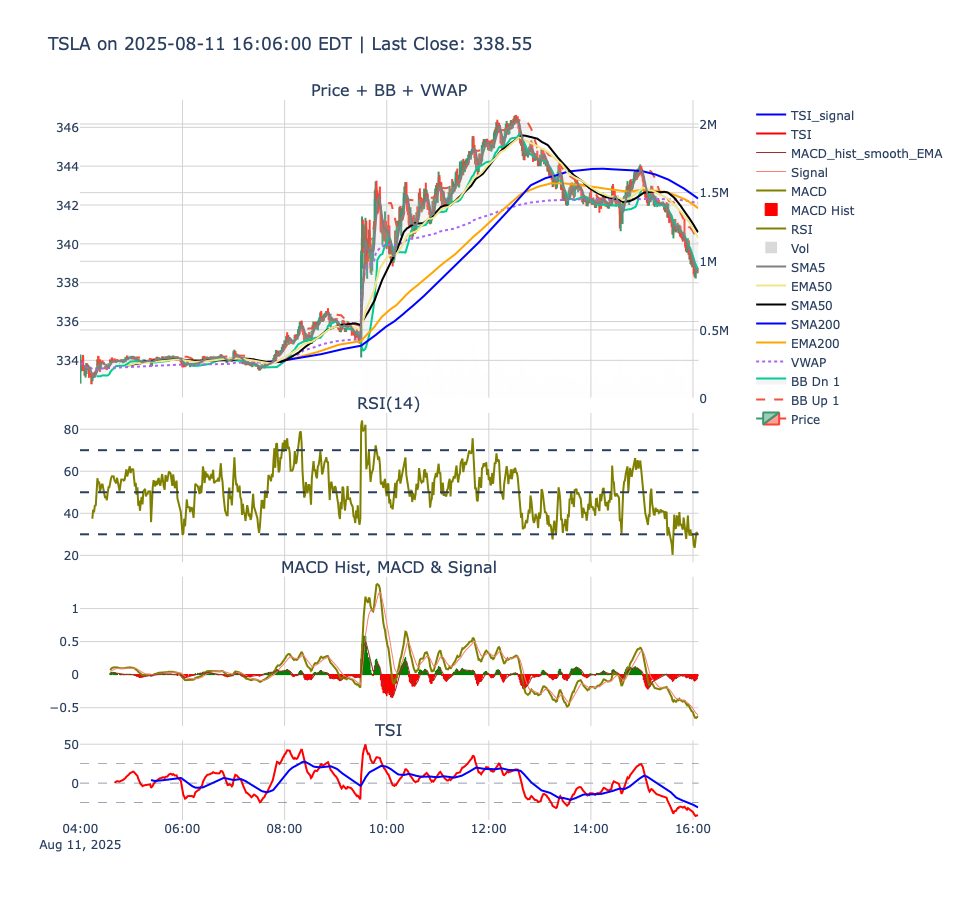

⚠️ WebSocket Error: received 1008 (policy violation); then sent 1008 (policy violation)


In [16]:
X="TSLA"

df_rest = fetch_polygon_data_rest(ticker=X,api_key=API_KEY,start_date=start_date,end_date=end_date,
                                  start_time=start_time,end_time=end_time,multiplier=multiplier,timespan=timespan,limit=limit)
df_rest = add_indicators_and_signals(df_rest) # OPTIONAL

df_merged = df_rest  # start with REST data

event_type="AM"

await run_ws(df_rest, X ,event_type)


In [17]:
import asyncio
import websockets
import json
import pandas as pd

async def get_one_live_row(ticker):
    """
    Connect to Polygon WebSocket, wait for one AM bar,
    and return it as a 1-row DataFrame with extra columns.
    """
    uri = "wss://socket.polygon.io/stocks"
    async with websockets.connect(uri) as ws:
        # Authenticate
        await ws.send(json.dumps({"action": "auth", "params": API_KEY}))
        
        # Subscribe to aggregate-minute bar for the ticker
        await ws.send(json.dumps({"action": "subscribe", "params": f"AM.{ticker}"}))
        print(f"📡 Waiting for one live bar for {ticker}...")

        while True:
            response = await ws.recv()
            messages = json.loads(response)

            for msg in messages:   # keep msg for raw message
                if msg.get("ev") == "AM":   # Aggregate-minute bar

#----------------------------------------------------------------------------------------------
                    ET_ZONE = ZoneInfo("America/New_York")
                    time_utc = pd.to_datetime(msg["s"], unit="ms", utc=True)
                    time_est = time_utc.tz_convert(ET_ZONE)

                    df = pd.DataFrame([{
                        "open": msg["o"],
                        "high": msg["h"],
                        "low": msg["l"],
                        "close": msg["c"],
                        "volume": msg["v"],
                        "t": msg["s"], 
                        "trades": msg['z'], 
                        "vwap": msg['vw'] ,
                        "TIME_EST": time_est,     
                    }])
#----------------------------------------------------------------------------------------------

                    print("✅ Received one live bar as DataFrame:")
                    return df   # Return DataFrame and exit


📡 Waiting for one live bar for TSLA...
✅ Received one live bar as DataFrame:


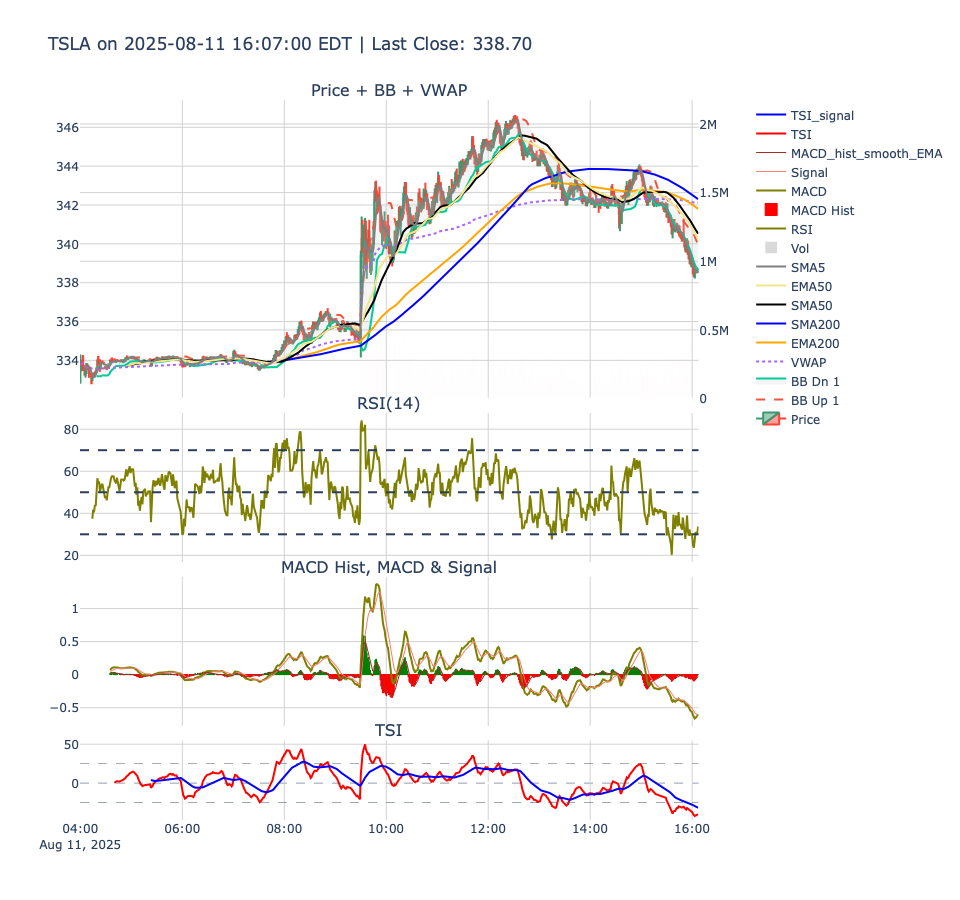

In [18]:
df_rest = fetch_polygon_data_rest(ticker=X,api_key=API_KEY,start_date=start_date,end_date=end_date,
                                  start_time=start_time,end_time=end_time,multiplier=multiplier,timespan=timespan,limit=limit)

df_live = await get_one_live_row(X)

df_merged = merge_rest_and_live(df_rest, df_live)
df_merged = add_indicators_and_signals (df_merged)
df_merged.tail(4)
plot_df_merged(df_merged,X)